# Les alliances entre entreprises de la tech : structuration, cluster et dépendance

Problématique 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import networkx as nx

## Chargement des données

In [61]:
deal = pd.read_csv("alliances_tech_j.csv",skiprows=5)
deal.head()

,Entreprise A,Entreprise B,Type d'alliance,Date,Concurrence,Explication alliance,Source,commentaire
0,Adobe,Figma,Tentative d'acquisition,NaN,NaN,Tentative d’acquisition stratégique - annulée,https://www.forbes.fr/business/adobe-met-fin-a...,NaN
1,Alibaba,Baidu,Accord de coopération stratégique,NaN,NaN,Collaboration sur IA générative,https://consent.yahoo.com/v2/collectConsent?se...,NaN
2,Alibaba,Apple,Accord de coopération stratégique,NaN,NaN,Partenariat sur l'IA en Chine,https://www.lesechos.fr/tech-medias/intelligen...,NaN
3,Amazon,Nvidia,Accord de coopération stratégique,NaN,NaN,Partenariat sur cloud et GPU pour IA générativ...,https://www.tradingsat.com/amazoncom-US0231351...,partenaire depuis 14ans
4,Amazon,Verizon,Accord de coopération stratégique,NaN,NaN,Partenariat edge computing 5G,https://www.cnbc.com/2021/10/26/verizon-partne...,NaN


In [62]:
info = pd.read_csv("companies_raw_j.csv")
info.head()

,Entreprises,ISIN,Pays,CA,Budget R&D,Taille entreprise,Secteur activité premier,Actionnaire majoritaire,OUI,NON
0,Anthropic,"pas coté, CA estimé",US,"4,000 Md$ (2024)",NaN,Grande (1035 employés),IA,Amazon,False,True
1,Rivian,US76954A1034,US,"4,97 Md$","1,539 Md$",Grande (14 861 employés),Automobile,Amazon,False,False
2,Mistral AI,"pas coté, CA estimé",France,100 millions $,NaN,Moyenne (300 employés),IA,ASML,False,False
3,Mercedes-Benz,NaN,Allemagne,"168,444 Md$","11,220 Md$",Grande (163 132 employés),Automobile,BAIC,False,NaN
4,Aligned Data Centers,pas coté,US,40 Mds $,NaN,Grande (308 employés),Infastructure Data,BlackRock,False,True


In [6]:
deal["Type d'alliance"].value_counts()

Type d'alliance
Accord de coopération stratégique          72
Investissement                             20
Client/fournisseur                         15
Jointventure                                5
Accord de publicité                         3
Petite Acquisition                          3
Acquisition                                 3
Tentative d'acquisition                     2
Transfert de technologies/connaissances     1
Ancien partenariat                          1
FUTUR collab                                1
Name: count, dtype: int64

In [40]:
info["Secteur activité premier "].value_counts()

Secteur activité premier 
Industrie technologique                           24
Logiciels                                         21
Intelligence Artificielle                         10
Plateformes, médias et connectivité               10
Cloud et infrastructures/protection de données     8
Logiciels                                          1
Name: count, dtype: int64

In [9]:
deal_save= deal

## Nettoyage

In [63]:
deal = deal[
    (deal["Type d'alliance"] != "FUTUR collab") &
    (deal["Type d'alliance"] != "Petite Acquisition") &
    (deal["Type d'alliance"] != "Ancien partenariat") &
    (deal["Type d'alliance"] != "Accord de publicité") &
    (deal["Type d'alliance"] != "Tentative d'acquisition") &
    (deal["Type d'alliance"] != "Transfert de propriété intellectuelle") &
    (deal["Type d'alliance"] != "Ancien partenariat")]

In [64]:
# Liste des termes à remplacer
alphabet_alias = [ "Google", "Waymo","GOOGLE", "google","Google DeepMind", "Google DeepMind (A)", "deepmind", "Google Deep Ming", "Google Cloud" ]
openai_alias =["Open AI", "Open Ai", "OpenAi"]
meta_alias=["meta", "Facebook", "Meta"]
amazon_alias =["Amazon", "AWS"]
YT_alias =["Youtube"]

# Fonction de nettoyage pour supprimer les suffixes entre parenthèses
def remove_parentheses(text):
    return re.sub(r"\s*\([^)]*\)$", "", text) 
    
# Application sur les deux colonnes
for col in ['Entreprise A', 'Entreprise B']:
    deal[col] = deal[col].astype(str).str.strip()            # trim espaces
    deal[col] = deal[col].apply(remove_parentheses)          # enlève parenthèse finale
    deal[col] = deal[col].replace(alphabet_alias, "Alphabet", regex=False)  # remplace variantes Alphabet
    deal[col] = deal[col].replace(openai_alias, "OpenAI", regex=False) 
    deal[col] = deal[col].replace(meta_alias, "Meta", regex=False)  
    deal[col] = deal[col].replace(amazon_alias, "Amazon", regex=False)  
    deal[col] = deal[col].replace(YT_alias, "YouTube", regex=False)  
    deal[col] = deal[col].str.strip()   


display((deal["Entreprise A"].unique()))
display((deal["Entreprise B"].unique()))

for col in ['Pays']:
    info[col] = info[col].replace("US", "Etats Unis", regex=False)  # remplace US par Etats Unis
    

array(['Alibaba', 'Amazon', 'AMD', 'Anthropic', 'Apple', 'Baidu',
       'Broadcom', 'BYD', 'Databricks', 'Ericsson', 'Alphabet', 'Huawei',
       'IBM', 'OpenAI', 'Intel', 'Lyft', 'Microsoft', 'MediaTek', 'Meta',
       'Nokia', 'Nvidia', 'Oracle', 'Qualcomm', 'Rivian', 'Salesforce',
       'Samsung', 'Snowflake', 'Sony', 'Spotify', 'Tesla', 'Thales',
       'TSMC', 'Uber', 'Toyota', 'Honda', 'Cruise', 'Red Hat', 'Arm',
       'Mercedes-Benz', 'ASML', 'SAP', 'Capgemini', 'Deepseek'],
      dtype=object)

array(['Baidu', 'Apple', 'Nvidia', 'Verizon', 'Hugging Face', 'SAP',
       'Anthropic', 'TSMC', 'Salesforce', 'Alphabet', 'Broadcom',
       'Foxconn', 'Adobe', 'Uber', 'Huawei', 'Deepseek', 'Microsoft',
       'Orange', 'Samsung', 'Tencent', 'Vodafone Group', 'Red Hat',
       'Oracle', 'LinkedIn', 'Scale AI', 'Amazon', 'CoreWeave', 'Meta',
       'OpenAI', 'AT&T', 'Databricks', 'GitHub', 'Intel', 'AMD',
       'ByteDance', 'Qualcomm', 'Honda', 'Volvo', 'Cruise',
       'General Motors', 'Arm', 'BharatGen', 'Aligned Data Centers',
       'Mistral AI', 'Snowflake', 'Nscale'], dtype=object)

## Graphe non orienté complet

In [16]:
G = nx.from_pandas_edgelist(deal, 'Entreprise A', 'Entreprise B')
print(f"Nombre d'entreprises : {G.number_of_nodes()} | Nombre d'alliances : {G.number_of_edges()}")


Nombre d'entreprises : 62 | Nombre d'alliances : 101


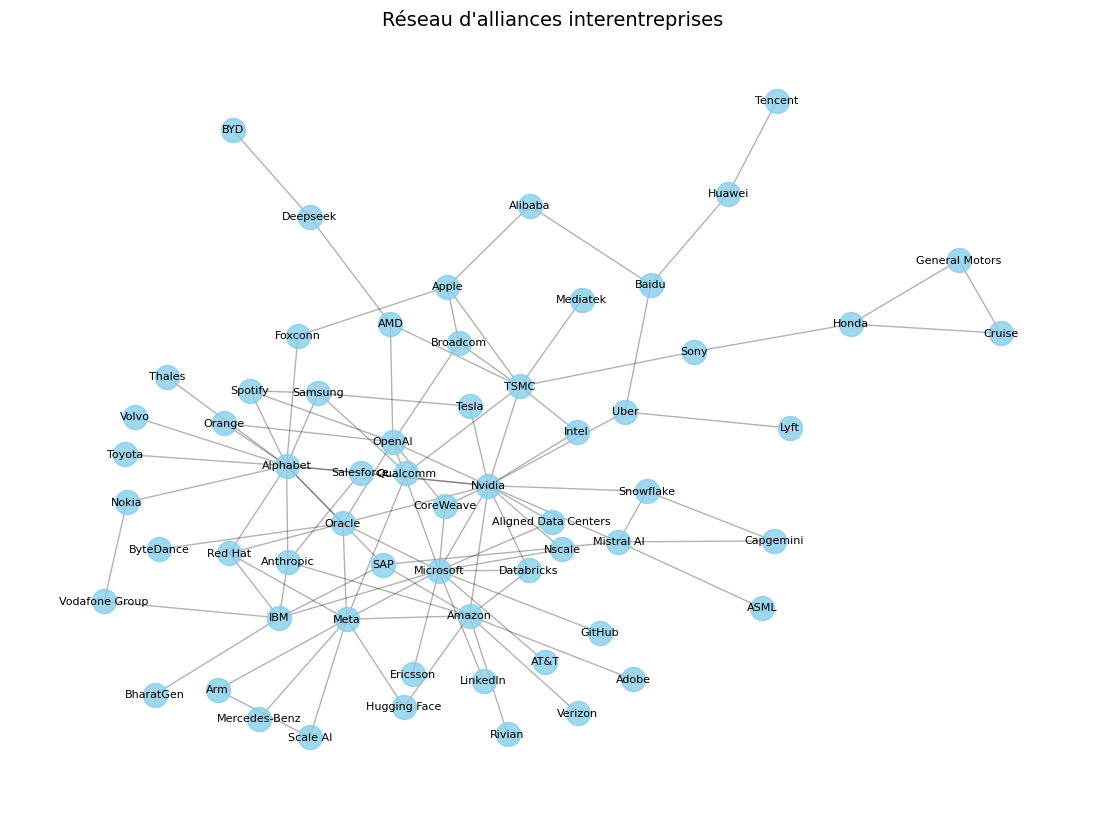

In [10]:
plt.figure(figsize=(14, 10))
pos = nx.kamada_kawai_layout(G, scale=3)  # positionnement esthétique
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Réseau d'alliances interentreprises", fontsize=14)
plt.axis('off')
plt.show()

In [13]:
from pyvis.network import Network

# Créer un réseau interactif
net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black")

# Charger les données du graphe NetworkX
net.from_nx(G)

# Options esthétiques
net.force_atlas_2based()  # disposition plus harmonieuse
net.show_buttons(filter_=['physics'])  # pour ajuster l'espacement dans le navigateur
net.write_html("reseau_alliances.html")

## Graphe orienté

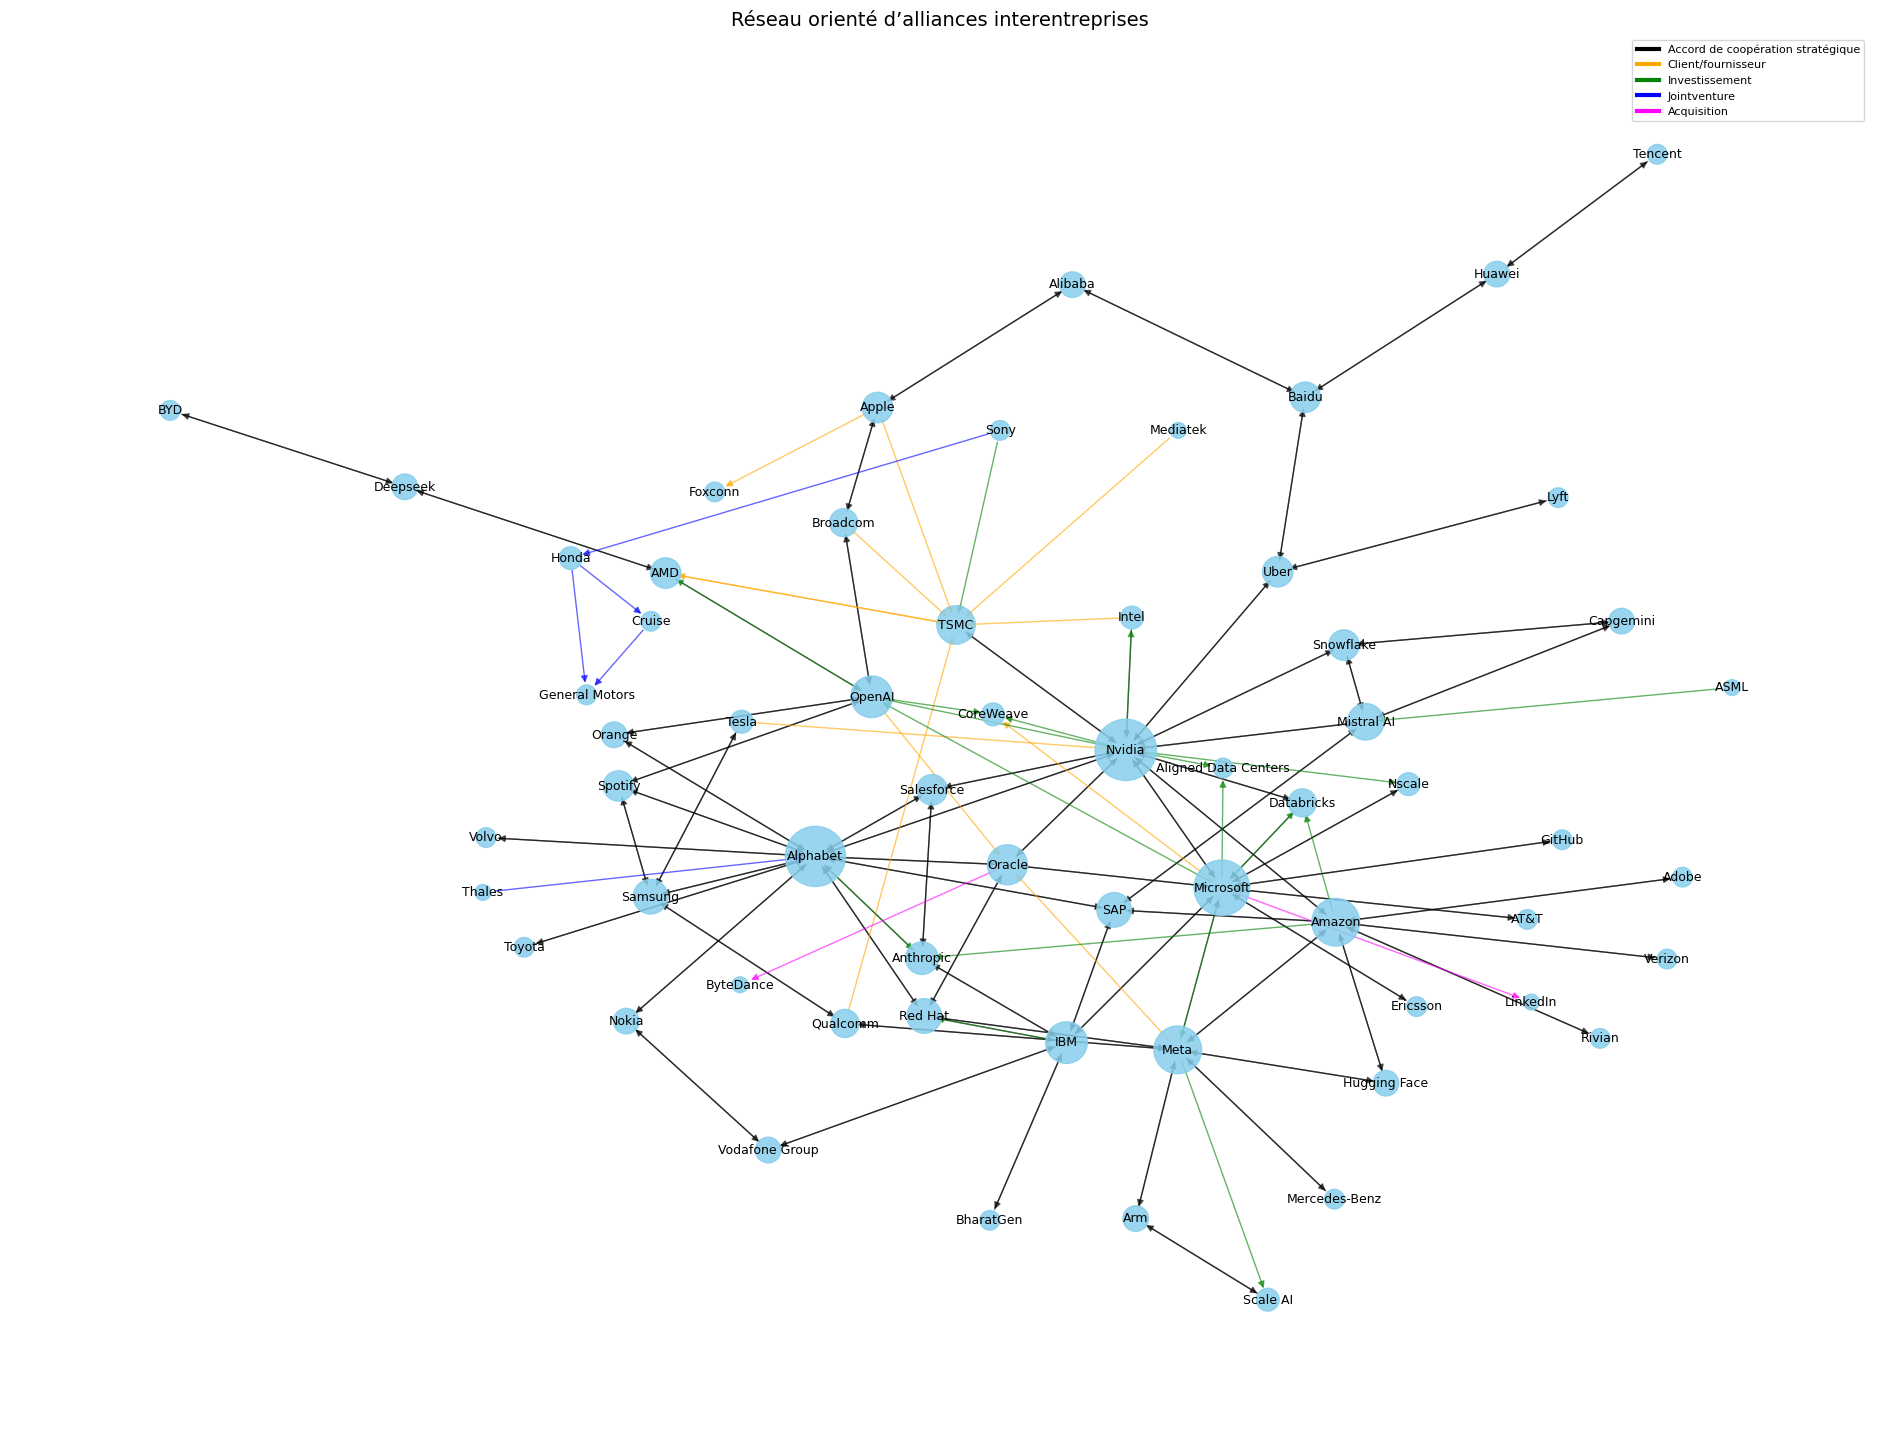

Nombre d’entreprises : 62 | Nombre d’alliances : 172


In [14]:
# Création du graphe orienté
G = nx.DiGraph()

# Dictionnaire de couleurs par type d’alliance
couleurs = {
    "Accord de coopération stratégique": "black",
    "Client/fournisseur": "orange",
    "Investissement": "green",
    "Jointventure": "blue",
    "Acquisition" : "fuchsia",
}

# Ajout des arêtes selon le type
for _, row in deal.iterrows():
    a, b, type_alliance = row["Entreprise A"], row["Entreprise B"], row["Type d'alliance"]

    if type_alliance == "Accord de coopération stratégique":
        # lien symétrique : les deux directions
        G.add_edge(a, b, type=type_alliance)
        G.add_edge(b, a, type=type_alliance)
    else:
        # lien orienté (A -> B)
        G.add_edge(a, b, type=type_alliance)

# Positionnement des nœuds
pos = nx.kamada_kawai_layout(G, scale=4)
pos["MediaTek"] [0]= 0.4 
pos["Foxconn"]=[-1.29578652,  1.84331]
pos["General Motors"]=[-1.76486549,  0.54732702]
pos["CoreWeave"]=[-0.27767,  0.422594 ]
pos["Honda"]=[-1.82274346,  1.42093455]

# Taille des nœuds selon le degré
deg = dict(G.degree())
node_sizes = [deg[n]*70 + 60 for n in G.nodes()]

# Nœuds
plt.figure(figsize=(24, 18))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.85)

# Dessiner les arêtes selon leur type
for type_alliance, color in couleurs.items():
    edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == type_alliance]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, alpha=0.6, arrows=True, arrowsize=10)

# Ajouter les labels
nx.draw_networkx_labels(G, pos, font_size=9)

# Légende manuelle
for type_alliance, color in couleurs.items():
    plt.plot([], [], color=color, label=type_alliance, linewidth=3)
plt.legend(loc="best", fontsize=8)

plt.title("Réseau orienté d’alliances interentreprises", fontsize=14)
plt.axis("off")
plt.savefig("reseau_alliances.png", dpi=300, bbox_inches="tight") 
plt.show()

print(f"Nombre d’entreprises : {G.number_of_nodes()} | Nombre d’alliances : {G.number_of_edges()}")


## Mesures globales : 

In [23]:
# Mesures rapides + viz
G_ud = G.to_undirected()
density = nx.density(G_ud)
components = nx.number_connected_components(G_ud)
giant = G_ud.subgraph(max(nx.connected_components(G_ud), key=len)).copy() if G_ud.number_of_nodes() else G_ud
avg_path = nx.average_shortest_path_length(giant) if (giant.number_of_nodes()>1 and nx.is_connected(giant)) else np.nan
print(f" Densité={density:.4f} | Composantes={components} | Dist. moyenne={(avg_path if not np.isnan(avg_path) else 'N/A')}")

deg = dict(G.degree())
btw = nx.betweenness_centrality(G_ud, normalized=True)
clo = nx.closeness_centrality(G_ud)
df_meas = pd.DataFrame({
    "Company": list(G.nodes()),
    "Degree": [deg[n] for n in G.nodes()],
    "Betweenness": [btw.get(n,0) for n in G.nodes()],
    "Closeness": [clo.get(n,0) for n in G.nodes()]
}).sort_values(["Degree","Betweenness"], ascending=[False,False])

print("Top 10 par degré:")
print(df_meas.head(10))

# --- Mesures globales (robustes) ---
# Pour un graphe orienté, on calcule les mesures de "connectivité" sur la version non orientée
G_ud = G.to_undirected()

# composantes faibles (non orienté)
components = list(nx.connected_components(G_ud)) if G_ud.number_of_nodes() else []
num_components = len(components)
giant = G_ud.subgraph(max(components, key=len)).copy() if components else G_ud

# densité
density = nx.density(G_ud)

# distance moyenne (sur la composante géante uniquement)
if giant.number_of_nodes() > 1 and nx.is_connected(giant):
    avg_path = nx.average_shortest_path_length(giant)
else:
    avg_path = np.nan

# diamètre (sur la composante géante ; défini seulement si connectée et >1 nœud)
try:
    diameter = nx.diameter(giant) if giant.number_of_nodes() > 1 and nx.is_connected(giant) else np.nan
except nx.NetworkXError:
    diameter = np.nan

# (bonus souvent demandé) rayon du réseau (sur la composante géante)
try:
    radius = nx.radius(giant) if giant.number_of_nodes() > 1 and nx.is_connected(giant) else np.nan
except nx.NetworkXError:
    radius = np.nan

# (bonus utile) clustering global (transitivity) sur non orienté
transitivity = nx.transitivity(G_ud) if G_ud.number_of_nodes() > 0 else np.nan

# (optionnel) mesures de forte connexité (composantes fortement connexes pour le graphe orienté)
#num_strong_cc = nx.number_strongly_connected_components(G) if G.number_of_nodes() > 0 else 0

print(f"""
 Mesures globales
- Densité (non orienté)              : {density:.4f}
- Distance moyenne (giant)           : {avg_path if not np.isnan(avg_path) else 'N/A'}
- Diamètre (giant)                   : {diameter if not np.isnan(diameter) else 'N/A'}
- Rayon (giant)                      : {radius if not np.isnan(radius) else 'N/A'}
- Transitivité (clustering global)   : {transitivity:.4f}
""".strip())


 Densité=0.0534 | Composantes=1 | Dist. moyenne=3.325753569539926
Top 10 par degré:
       Company  Degree  Betweenness  Closeness
4       Nvidia      16     0.472568   0.495935
12    Alphabet      14     0.217294   0.414966
22   Microsoft      13     0.203714   0.426573
3       Amazon       9     0.138092   0.388535
35        Meta       9     0.130358   0.374233
10        TSMC       8     0.225508   0.401316
29      OpenAI       8     0.101538   0.401316
30      Oracle       7     0.075792   0.420690
26         IBM       6     0.064524   0.344633
59  Mistral AI       5     0.055926   0.352601
Mesures globales
- Densité (non orienté)              : 0.0534
- Distance moyenne (giant)           : 3.325753569539926
- Diamètre (giant)                   : 8
- Rayon (giant)                      : 4
- Transitivité (clustering global)   : 0.1379


### Investissement

## Etude par pays

C:\Users\Admin\AppData\Local\Temp\ipykernel_37896\2861164428.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(pays_uniques))  # Colormap automatique


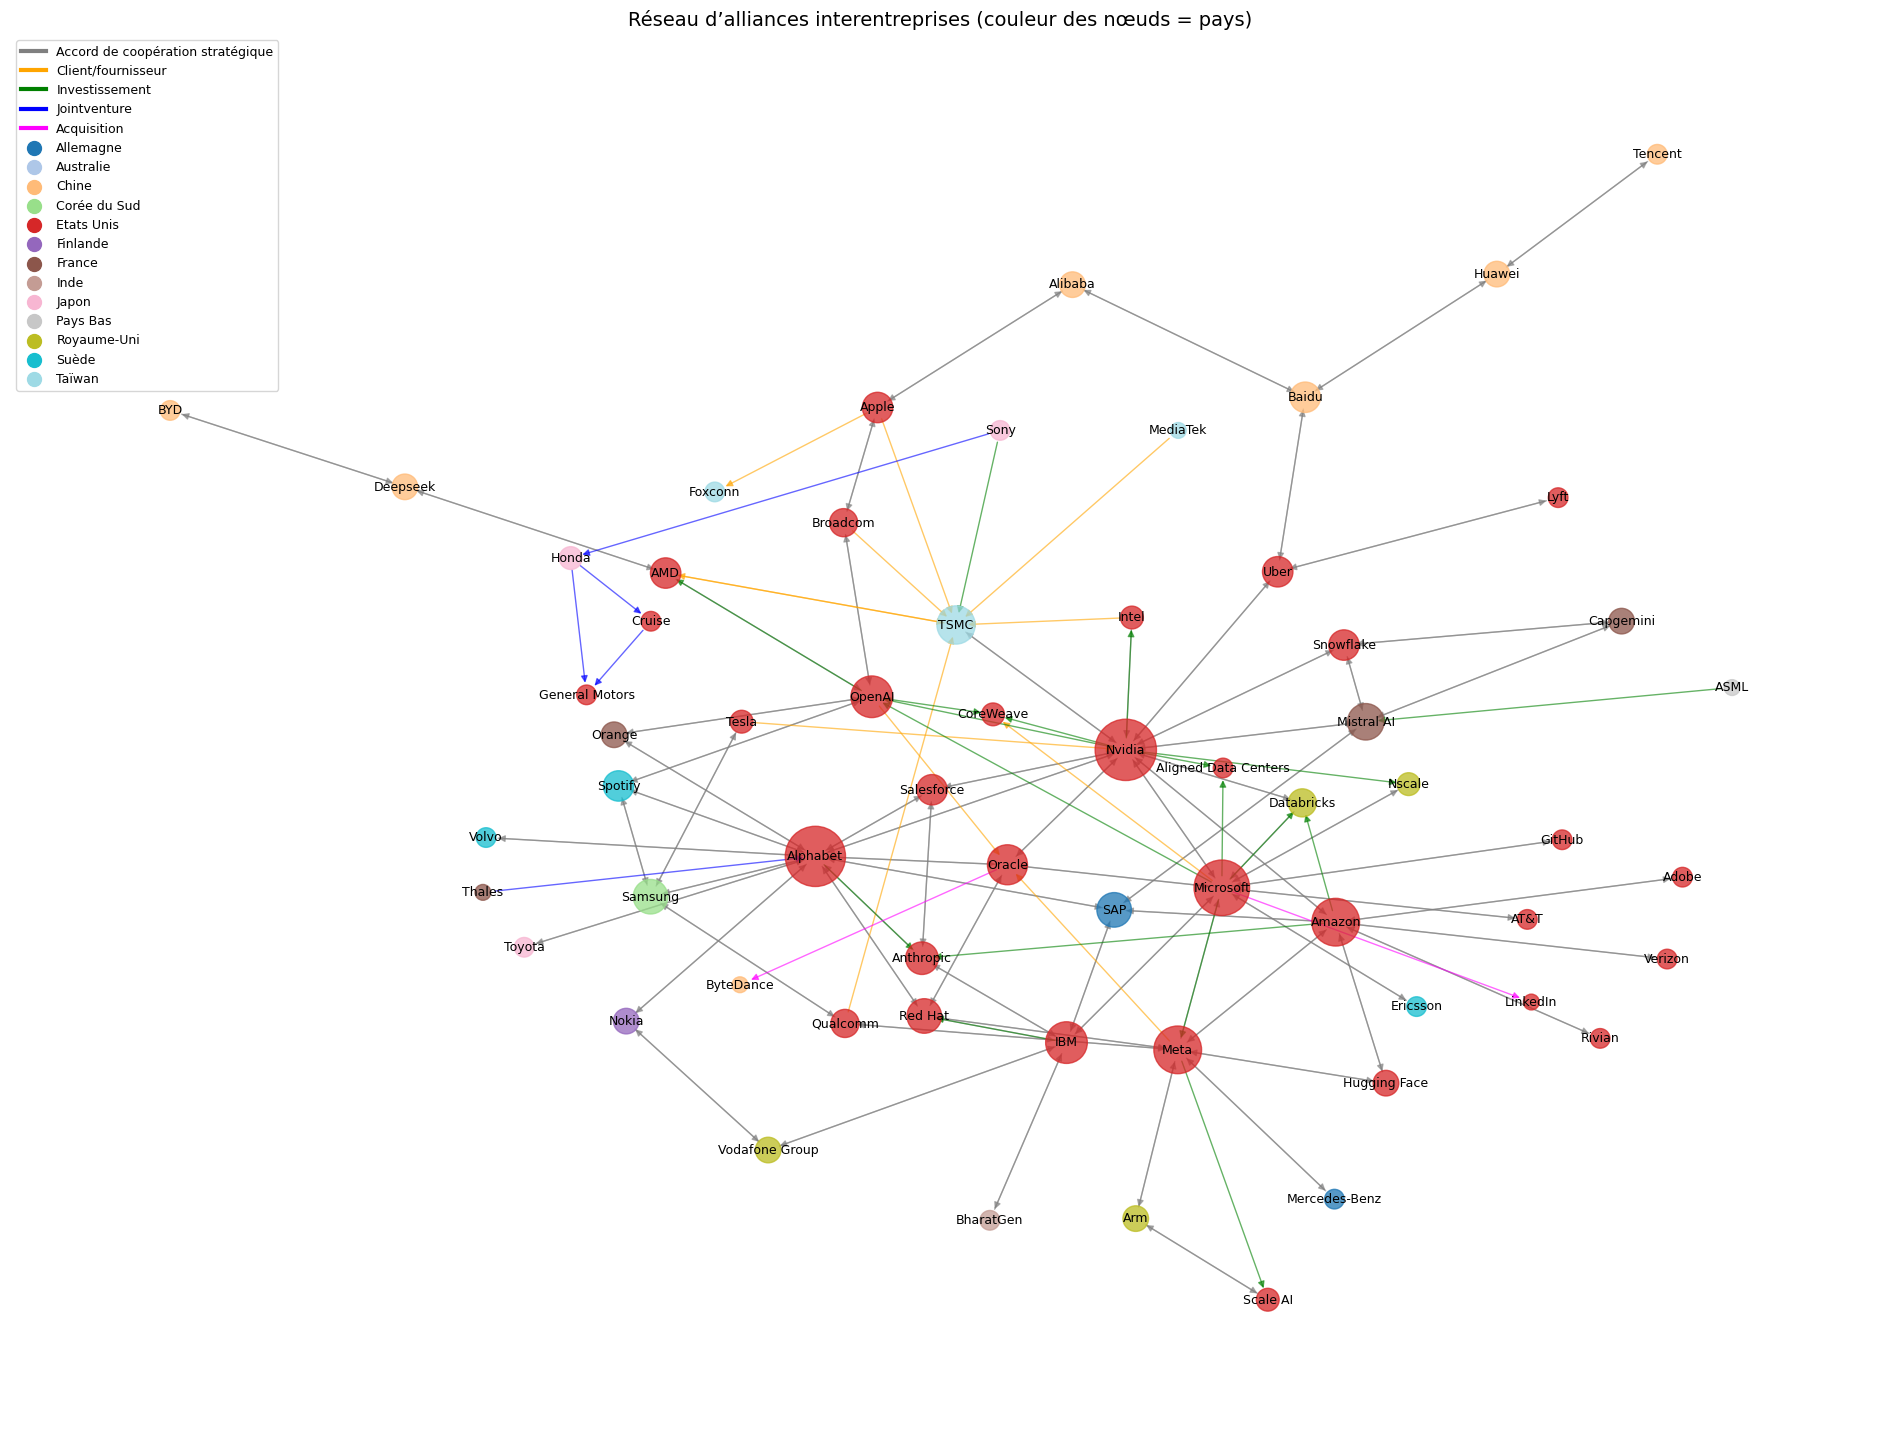

Nombre d’entreprises : 62 | Nombre d’alliances : 172


In [65]:
# --- Création du graphe orienté ---
Gpays = nx.DiGraph()

# Dictionnaire de couleurs par type d’alliance (arêtes)
couleurs = {
    "Accord de coopération stratégique": "grey",
    "Client/fournisseur": "orange",
    "Investissement": "green",
    "Jointventure": "blue",
    "Acquisition" : "fuchsia",
}

# --- Ajout des arêtes ---
for _, row in deal.iterrows():
    a, b, type_alliance = row["Entreprise A"], row["Entreprise B"], row["Type d'alliance"]
    if type_alliance == "Accord de coopération stratégique":
        Gpays.add_edge(a, b, type=type_alliance)
        Gpays.add_edge(b, a, type=type_alliance)
    else:
        Gpays.add_edge(a, b, type=type_alliance)

# --- Couleur des nœuds selon le pays ---
pays_dict = pd.Series(info["Pays"].values, index=info["Entreprises"]).to_dict()

# Palette de couleurs automatique pour les pays
pays_uniques = sorted(info["Pays"].dropna().unique())
cmap = plt.cm.get_cmap("tab20", len(pays_uniques))  # Colormap automatique
couleur_pays = {p: cmap(i) for i, p in enumerate(pays_uniques)}

# Couleur de chaque nœud (gris clair si pays inconnu)
node_colors = [couleur_pays.get(pays_dict.get(n, None), "lightgrey") for n in Gpays.nodes()]

# --- Positionnement des nœuds ---
pos = nx.kamada_kawai_layout(Gpays, scale=4)
pos["MediaTek"] [0]= 0.4 
pos["Foxconn"]=[-1.29578652,  1.84331]
pos["General Motors"]=[-1.76486549,  0.54732702]
pos["CoreWeave"]=[-0.27767,  0.422594 ]
pos["Honda"]=[-1.82274346,  1.42093455]
# --- Taille des nœuds proportionnelle au degré ---
deg = dict(Gpays.degree())
node_sizes = [60 + deg[n]*70 for n in Gpays.nodes()]

# --- Dessin ---
plt.figure(figsize=(24, 18))

# Nœuds colorés par pays
nx.draw_networkx_nodes(Gpays, pos, node_size=node_sizes, node_color=node_colors, alpha=0.75)

# Arêtes colorées par type d’alliance
for type_alliance, color in couleurs.items():
    edges = [(u, v) for u, v, d in Gpays.edges(data=True) if d["type"] == type_alliance]
    nx.draw_networkx_edges(Gpays, pos, edgelist=edges, edge_color=color, alpha=0.6, arrows=True, arrowsize=10)

# Labels
nx.draw_networkx_labels(Gpays, pos, font_size=9)

# --- Légendes ---
# 1. Légende des types d’alliance
for type_alliance, color in couleurs.items():
    plt.plot([], [], color=color, label=type_alliance, linewidth=3)
# 2. Légende des pays
for p, c in couleur_pays.items():
    plt.scatter([], [], color=c, label=p, s=100)

plt.legend(loc="best", fontsize=9)

plt.title("Réseau d’alliances interentreprises (couleur des nœuds = pays)", fontsize=14)
plt.axis("off")
plt.savefig("reseau_alliances_pays.png", dpi=300, bbox_inches="tight") 
plt.show()

print(f"Nombre d’entreprises : {Gpays.number_of_nodes()} | Nombre d’alliances : {Gpays.number_of_edges()}")


In [38]:
pos["Honda"]

array([-0.82274346,  1.32093455])

## Etude par domaines

#### redefinition des groupes

In [66]:

# Dictionnaire de regroupement
mapping_secteurs = {
    # 1. Logiciels métiers et services numériques
    "Logiciel": "Logiciels",
    "Logiciel transports": "Logiciels",
    "Logiciel musique": "Logiciels",


    # 2. Cloud et infrastructures/protection de données
    "Cloud": "Cloud et infrastructures/protection de données",
    "Infastructure Data": "Cloud et infrastructures/protection de données",
    "Infrastructure Data": "Cloud et infrastructures/protection de données",  # au cas où l’orthographe diffère
    "Cybersécurité":"Cloud et infrastructures/protection de données", 

    # 3. IA 
    "IA": "Intelligence Artificielle",

    # 4. Électronique
    "Electronique": "Industrie technologique",
    "Automobile ": "Industrie technologique",

    # 5. Plateformes et connectivité
    "Plateforme sociale ": "Plateformes, médias et connectivité" ,
    "Plateforme divertissement": "Plateformes, médias et connectivité",
    "Télécomm": "Plateformes, médias et connectivité",
    "e commerce": "Plateformes, médias et connectivité",
}

# Application du regroupement
info["Secteur activité premier "] = info["Secteur activité premier "].replace(mapping_secteurs)

# Vérification du résultat
print(info["Secteur activité premier "].value_counts())


Secteur activité premier 
Industrie technologique                           24
Logiciels                                         22
Intelligence Artificielle                         10
Plateformes, médias et connectivité               10
Cloud et infrastructures/protection de données     8
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_37896\4103324615.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Set3", len(secteur_uniques))  # Colormap automatique


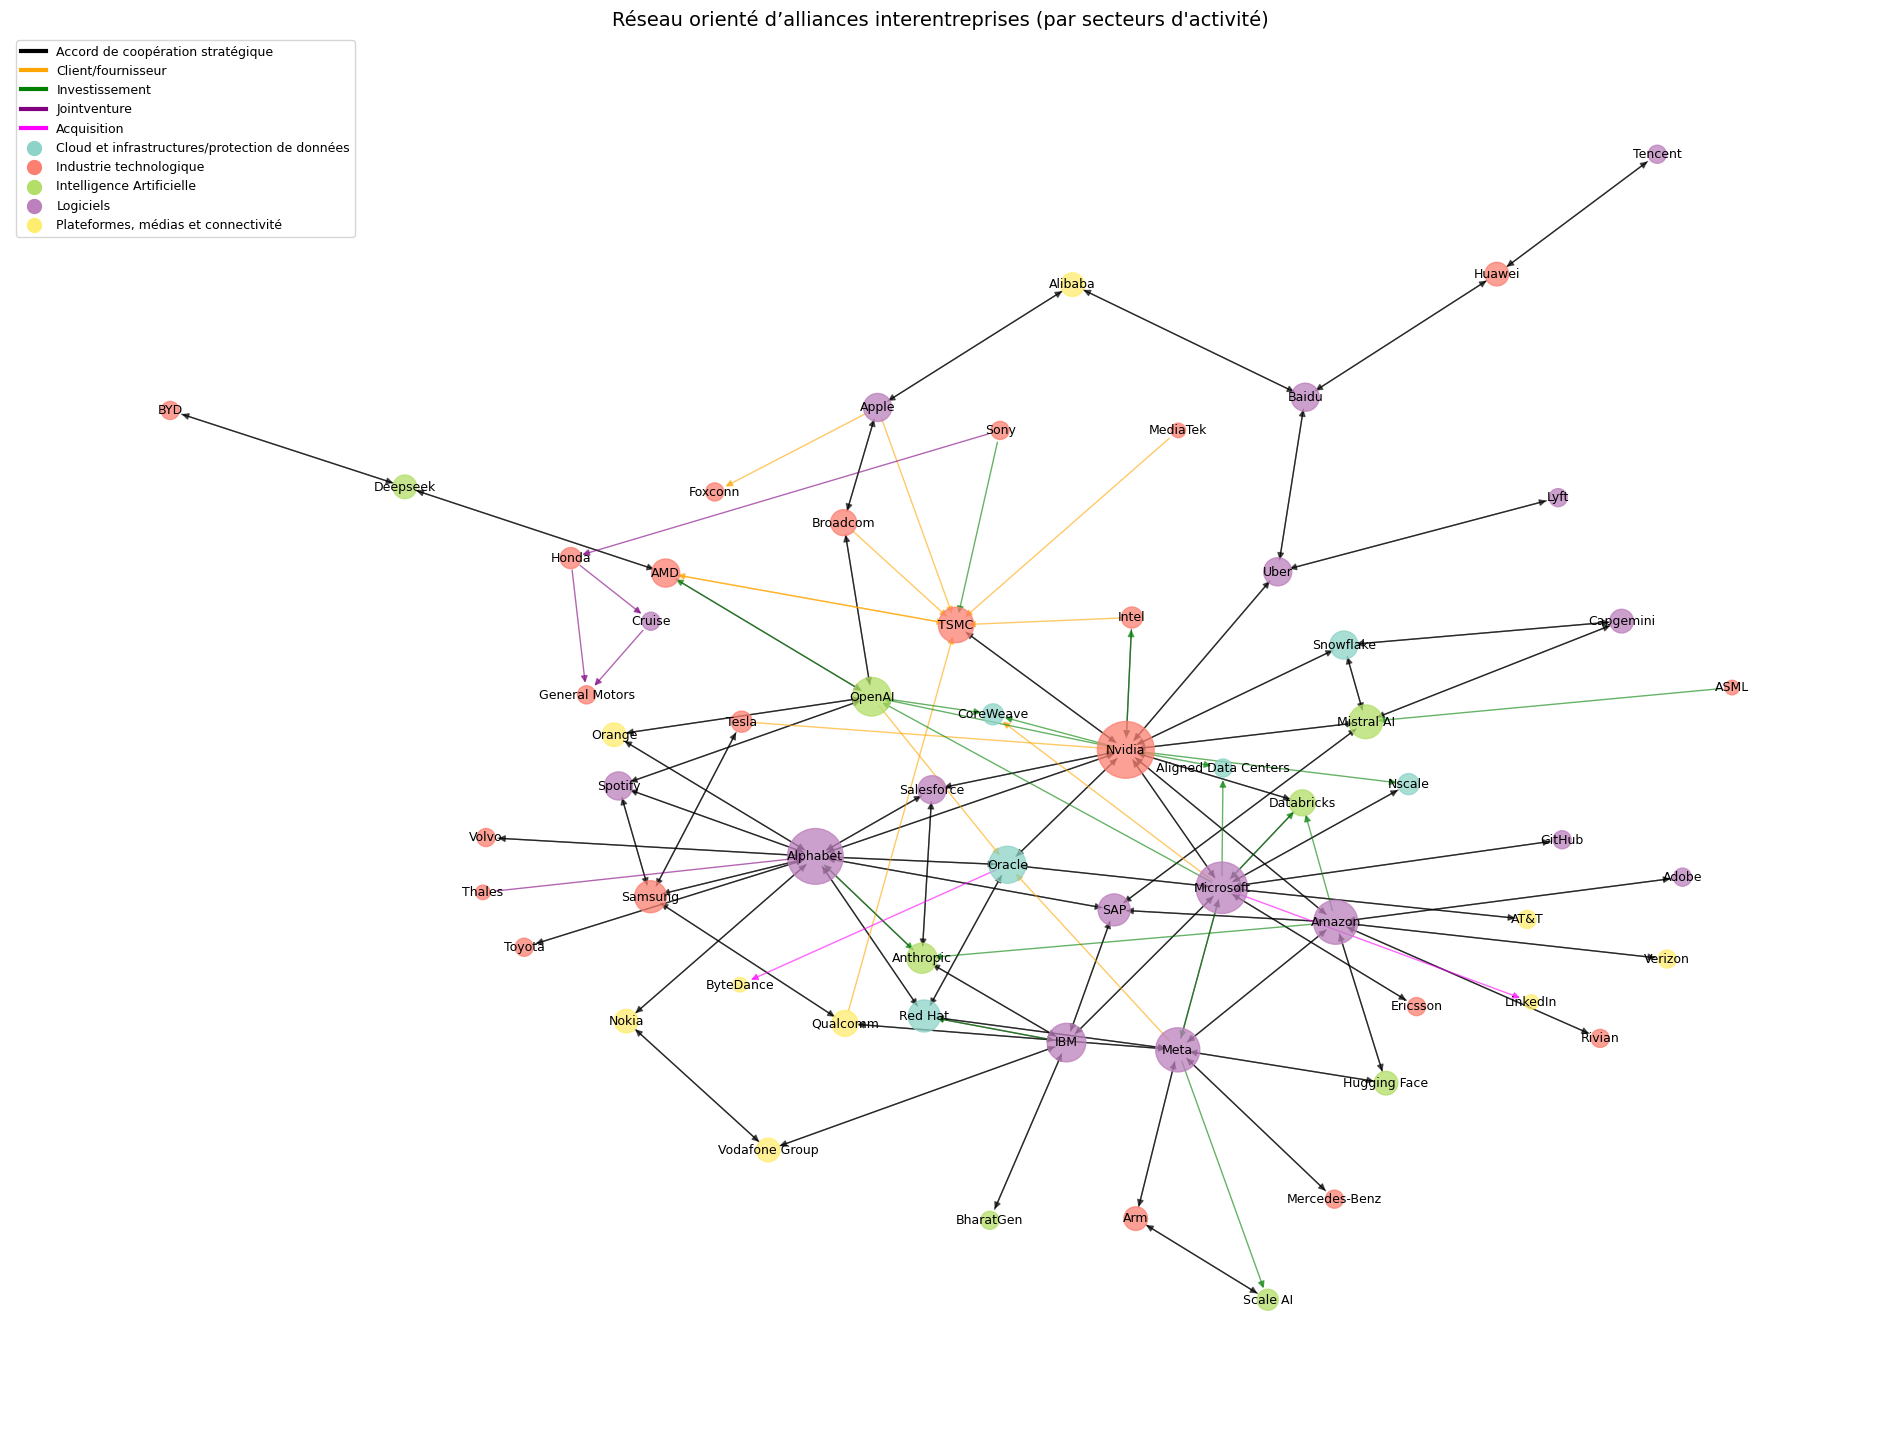

Nombre d’entreprises : 62 | Nombre d’alliances : 172


In [67]:
# --- Création du graphe orienté ---
Gsecteur = nx.DiGraph()

# Dictionnaire de couleurs par type d’alliance (arêtes)
couleurs = {
    "Accord de coopération stratégique": "black",
    "Client/fournisseur": "orange",
    "Investissement": "green",
    "Jointventure": "purple",
    "Acquisition" : "fuchsia",
}

# --- Ajout des arêtes ---
for _, row in deal.iterrows():
    a, b, type_alliance = row["Entreprise A"], row["Entreprise B"], row["Type d'alliance"]
    if type_alliance == "Accord de coopération stratégique":
        Gsecteur.add_edge(a, b, type=type_alliance)
        Gsecteur.add_edge(b, a, type=type_alliance)
    else:
        Gsecteur.add_edge(a, b, type=type_alliance)

# --- Couleur des nœuds selon le pays ---
# On crée un dictionnaire {entreprise: secteur}
secteur_dict = pd.Series(info['Secteur activité premier '].values, index=info["Entreprises"]).to_dict()

# Palette de couleurs automatique pour les pays
secteur_uniques = sorted(info['Secteur activité premier '].dropna().unique())
cmap = plt.cm.get_cmap("Set3", len(secteur_uniques))  # Colormap automatique
couleur_secteur = {p: cmap(i) for i, p in enumerate(secteur_uniques)}

# Couleur de chaque nœud (gris clair si pays inconnu)
node_colors = [couleur_secteur.get(secteur_dict.get(n, None), "lightgrey") for n in Gsecteur.nodes()]

# --- Positionnement des nœuds ---
pos = nx.kamada_kawai_layout(Gsecteur, scale=4)
pos["MediaTek"] [0]= 0.4 
pos["Foxconn"]=[-1.29578652,  1.84331]
pos["General Motors"]=[-1.76486549,  0.54732702]
pos["CoreWeave"]=[-0.27767,  0.422594 ]
pos["Honda"]=[-1.82274346,  1.42093455]


# --- Taille des nœuds proportionnelle au degré ---
deg = dict(Gsecteur.degree())
node_sizes = [50 + deg[n]*60 for n in Gsecteur.nodes()]

# --- Dessin ---
plt.figure(figsize=(24, 18))

# Nœuds colorés par pays
nx.draw_networkx_nodes(Gsecteur, pos, node_size=node_sizes, node_color=node_colors, alpha=0.75)

# Arêtes colorées par type d’alliance
for type_alliance, color in couleurs.items():
    edges = [(u, v) for u, v, d in Gpays.edges(data=True) if d["type"] == type_alliance]
    nx.draw_networkx_edges(Gsecteur, pos, edgelist=edges, edge_color=color, alpha=0.6, arrows=True, arrowsize=10)

# Labels
nx.draw_networkx_labels(Gsecteur, pos, font_size=9)

# --- Légendes ---
# 1. Légende des types d’alliance
for type_alliance, color in couleurs.items():
    plt.plot([], [], color=color, label=type_alliance, linewidth=3)
# 2. Légende des pays
for p, c in couleur_secteur.items():
    plt.scatter([], [], color=c, label=p, s=100)

plt.legend(loc="best", fontsize=9)

plt.title("Réseau orienté d’alliances interentreprises (par secteurs d'activité)", fontsize=14)
plt.axis("off")
plt.savefig("reseau_alliances_secteur.png", dpi=300, bbox_inches="tight")  # haute résolution, sans marges inutiles
plt.show()

print(f"Nombre d’entreprises : {Gpays.number_of_nodes()} | Nombre d’alliances : {Gpays.number_of_edges()}")


## Graphiques des mesures de centralité

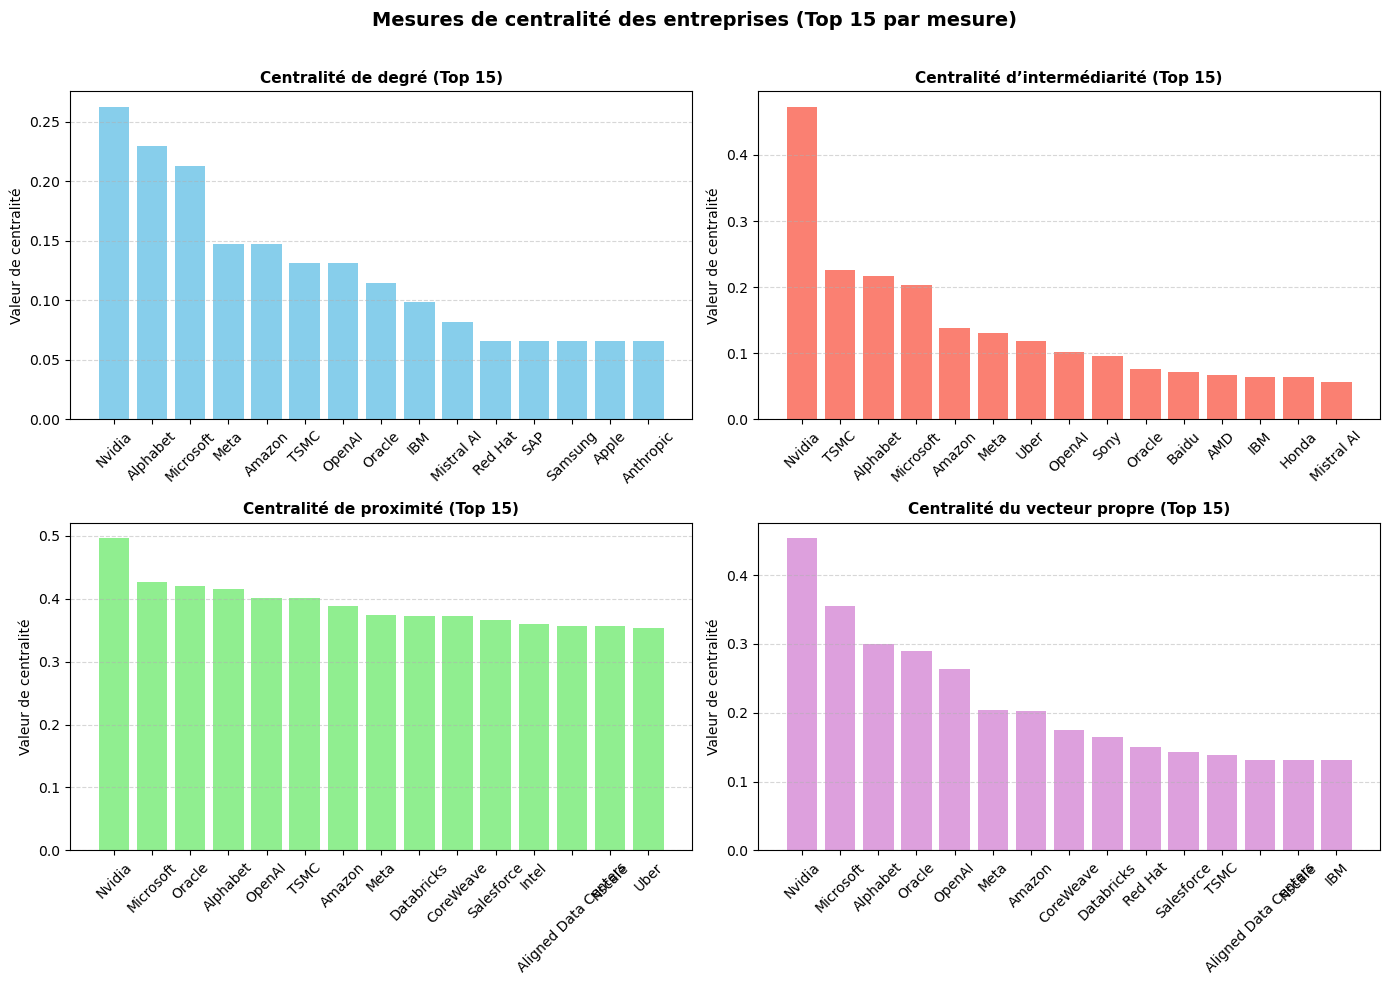

In [18]:
# --- (1) Calcul des mesures de centralité ---
deg_centrality = nx.degree_centrality(G)
bet_centrality = nx.betweenness_centrality(G)
clos_centrality = nx.closeness_centrality(G)
eig_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# --- (2) Conversion en DataFrame ---
df_centrality = pd.DataFrame({
    "Degré": deg_centrality,
    "Intermédiarité": bet_centrality,
    "Proximité": clos_centrality,
    "Vecteur propre": eig_centrality
})

# --- (3) Création des sous-graphiques ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Palette cohérente et titres
colors = ["skyblue", "salmon", "lightgreen", "plum"]
titles = [
    "Centralité de degré (Top 15)",
    "Centralité d’intermédiarité (Top 15)",
    "Centralité de proximité (Top 15)",
    "Centralité du vecteur propre (Top 15)"
]

# --- (4) Tracer les barplots triés individuellement ---
for i, (col, color, title) in enumerate(zip(df_centrality.columns, colors, titles)):
    top15 = df_centrality[col].sort_values(ascending=False).head(15)
    axes[i].bar(top15.index, top15.values, color=color)
    axes[i].set_title(title, fontsize=11, weight="bold")
    axes[i].set_ylabel("Valeur de centralité")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# --- (5) Ajustement de la mise en page ---
plt.suptitle("Mesures de centralité des entreprises (Top 15 par mesure)", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("centralites_top15_par_mesure.png", dpi=300, bbox_inches="tight")
plt.show()


## Etude des investissements

In [54]:
# pip install forceatlas2


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for forceatlas2: filename=ForceAtlas2-1.0-py3-none-any.whl size=6526 sha256=a0d8d12f51c56a1a9d1defb5eab6863a48f9eb375ea8fab630e7e20d5043a452
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\7b\6c\35\661e173d24eaff4dbf3a0fddc82be53d86fbcd743380e43abc
Successfully built forceatlas2
Note: you may need to restart the kernel to use updated packages.


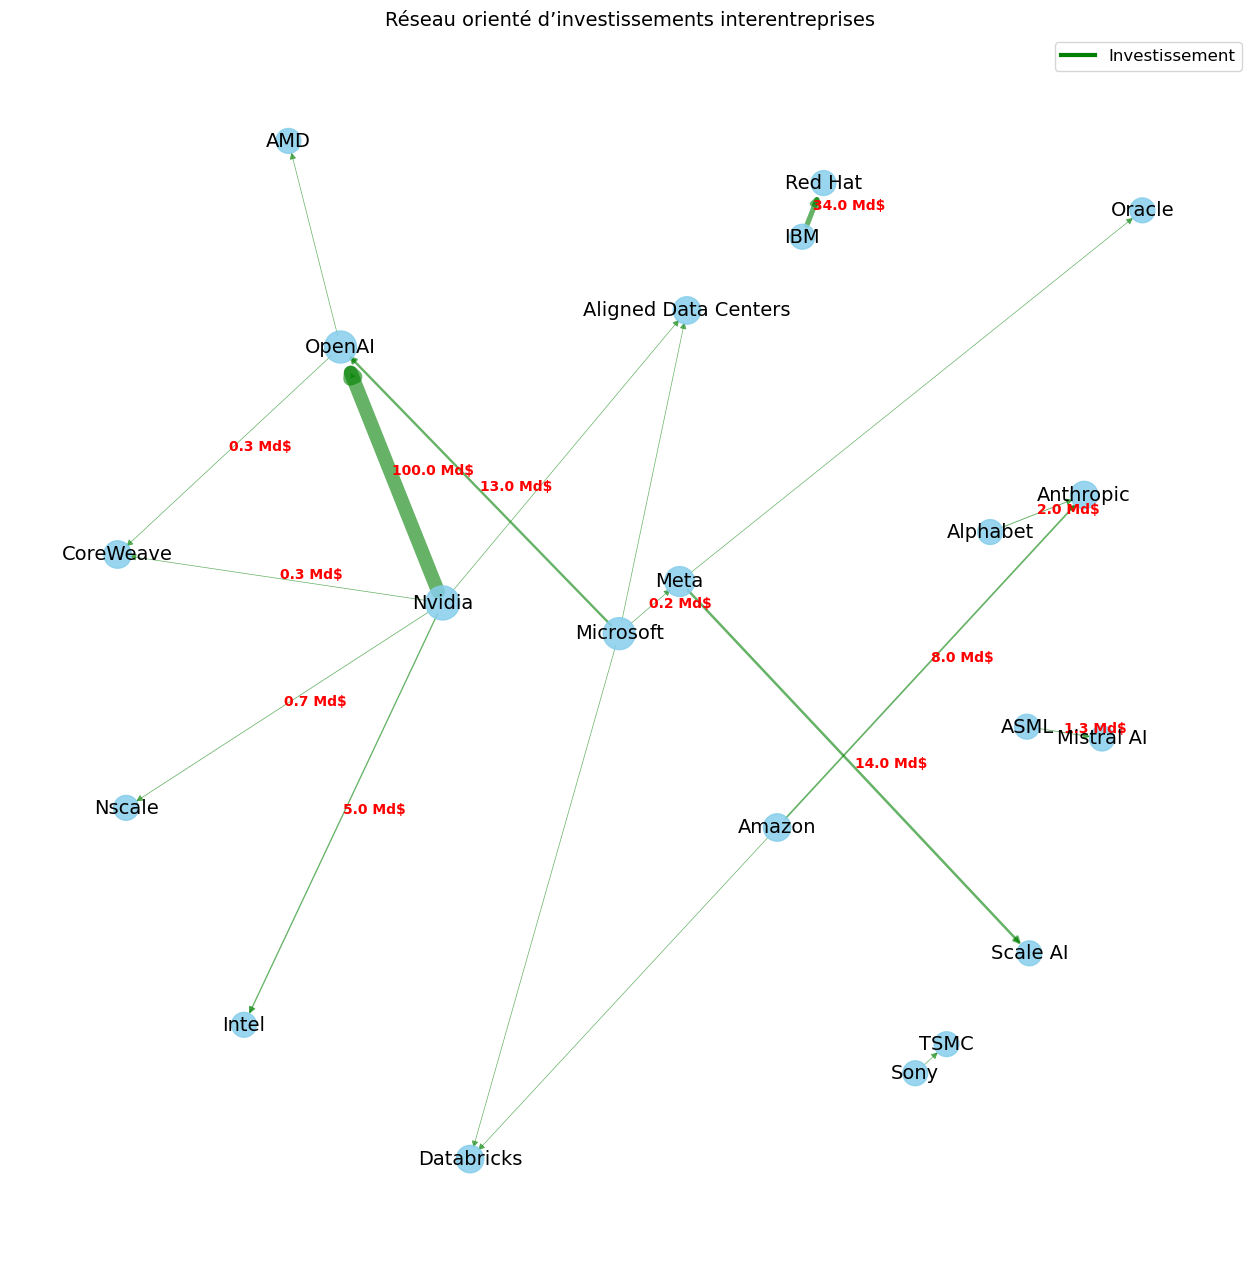

Nombre d’entreprises : 21 | Nombre d’alliances : 19


In [95]:

import re

# --- Création du graphe orienté ---
Ginvest = nx.DiGraph()

# Dictionnaire de couleurs par type d’alliance
couleurs = {"Investissement": "green"}

# --- Fonction de parsing des montants ---
def extraire_montant(explication):
    """
    Extrait un montant numérique d'une chaîne du type :
    '14 milliards $', '56MDS$', '300 millions$', etc.
    Renvoie le montant en milliards (float).
    """
    if not isinstance(explication, str):
        return None
    txt = explication.lower().replace(" ", "")
    match = re.search(r"([\d,.]+)", txt)
    if not match:
        return None
    montant = match.group(1).replace(",", ".")
    try:
        montant = float(montant)
    except ValueError:
        return None

    if "milliard" in txt or "mds" in txt or "milliards" in txt:
        return montant
    elif "million" in txt or "mio" in txt or "m" in txt or "millions" in txt :
        return montant / 1000  # conversion millions → milliards
    else:
        return montant

# --- Ajout des arêtes ---
for _, row in deal.iterrows():
    a, b, type_alliance = row["Entreprise A"], row["Entreprise B"], row["Type d'alliance"]

    if type_alliance in ["Investissement"]:
        montant = extraire_montant(row.get("Explication alliance", ""))
        Ginvest.add_edge(a, b, type=type_alliance, montant=montant)
   


# --- Positionnement des nœuds ---
#pos = nx.spring_layout(Ginvest, k=0.6, iterations=300, seed=42)

pos=nx.kamada_kawai_layout(Ginvest)
pos["Intel"]=[0.5175399 , 0.0] 
pos["Scale AI"]=[0.35866047, 0.3]
pos["IBM"]= [-0.34739223, 0.42281866]
pos["Mistral AI"]=[0.54771231, -0.2818141]
pos["Sony"]=[-0.18105236, -0.46961572]
pos["Oracle"]=[0.23105096, 0.43666126]

pos = nx.spring_layout(Ginvest, k=1.6, iterations=500, seed=42)
pos["AMD"][0]=-0.7
pos["Aligned Data Centers"][0]=0
pos["Oracle"][0]=0.8

# --- Taille des nœuds proportionnelle au degré ---
deg = dict(Ginvest.degree())
node_sizes = [250 + deg[n] * 70 for n in Ginvest.nodes()]

# --- Dessin ---
plt.figure(figsize=(16, 16))

# Nœuds
nx.draw_networkx_nodes(Ginvest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.85)

# --- Arêtes ---
for type_alliance, color in couleurs.items():
    edges = [(u, v, d) for u, v, d in Ginvest.edges(data=True) if d["type"] == type_alliance]

    if type_alliance == "Investissement":
        montants = [d["montant"] for _, _, d in edges if d["montant"] is not None]
        if montants:
            min_m, max_m = min(montants), max(montants)
            def width_scale(m):
                if m is None:
                    return 0.5
                return 0.5 + 9.5 * ((m - min_m) / (max_m - min_m) if max_m > min_m else 1)
            widths = [width_scale(d["montant"]) for _, _, d in edges]
        else:
            widths = [1] * len(edges)
    else:
        widths = [1.5] * len(edges)

    # Dessiner les arêtes
    nx.draw_networkx_edges(
        Ginvest, pos,
        edgelist=[(u, v) for u, v, _ in edges],
        edge_color=color,
        alpha=0.6,
        arrows=True,
        arrowsize=10,
        width=widths
    )

    # Ajouter les montants sur les arêtes d’investissement
    if type_alliance == "Investissement":
        for (u, v, d) in edges:
            if d["montant"] is not None:
                # Coordonnées du texte = milieu de l'arête
                x1, y1 = pos[u]
                x2, y2 = pos[v]
                xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
                plt.text(xm, ym, f"{d['montant']:.1f} Md$", fontsize=10, color="red", fontweight="bold")

# Labels des nœuds
nx.draw_networkx_labels(Ginvest, pos, font_size=14)

# Légende
for type_alliance, color in couleurs.items():
    plt.plot([], [], color=color, label=type_alliance, linewidth=3)
plt.legend(loc="best", fontsize=12)

plt.title("Réseau orienté d’investissements interentreprises", fontsize=14)
plt.savefig("investissements.png", dpi=300, bbox_inches="tight")
plt.axis("off")
plt.show()

print(f"Nombre d’entreprises : {Ginvest.number_of_nodes()} | Nombre d’alliances : {Ginvest.number_of_edges()}")



In [86]:
pos["Aligned Data Centers"]


array([0.4       , 0.04827586])

## Mesures globales : 

In [25]:
import numpy as np
import networkx as nx

# --- Mesures globales (robustes) ---
# Pour un graphe orienté, on calcule les mesures de "connectivité" sur la version non orientée
G_ud = G.to_undirected()

# composantes faibles (non orienté)
components = list(nx.connected_components(G_ud)) if G_ud.number_of_nodes() else []
num_components = len(components)
giant = G_ud.subgraph(max(components, key=len)).copy() if components else G_ud

# densité
density = nx.density(G_ud)

# distance moyenne (sur la composante géante uniquement)
if giant.number_of_nodes() > 1 and nx.is_connected(giant):
    avg_path = nx.average_shortest_path_length(giant)
else:
    avg_path = np.nan

# diamètre (sur la composante géante ; défini seulement si connectée et >1 nœud)
try:
    diameter = nx.diameter(giant) if giant.number_of_nodes() > 1 and nx.is_connected(giant) else np.nan
except nx.NetworkXError:
    diameter = np.nan

# (bonus souvent demandé) rayon du réseau (sur la composante géante)
try:
    radius = nx.radius(giant) if giant.number_of_nodes() > 1 and nx.is_connected(giant) else np.nan
except nx.NetworkXError:
    radius = np.nan

# (bonus utile) clustering global (transitivity) sur non orienté
transitivity = nx.transitivity(G_ud) if G_ud.number_of_nodes() > 0 else np.nan

# (optionnel) mesures de forte connexité (composantes fortement connexes pour le graphe orienté)
num_strong_cc = nx.number_strongly_connected_components(G) if G.number_of_nodes() > 0 else 0

print(f"""
🌐 Mesures globales
- Densité (non orienté)              : {density:.4f}
- Composantes faibles (non orienté)  : {num_components}
- Composantes fortement connexes (→) : {num_strong_cc}
- Distance moyenne (giant)           : {avg_path if not np.isnan(avg_path) else 'N/A'}
- Diamètre (giant)                   : {diameter if not np.isnan(diameter) else 'N/A'}
- Rayon (giant)                      : {radius if not np.isnan(radius) else 'N/A'}
- Transitivité (clustering global)   : {transitivity:.4f}
""".strip())


🌐 Mesures globales
- Densité (non orienté)              : 0.0386
- Composantes faibles (non orienté)  : 2
- Composantes fortement connexes (→) : 26
- Distance moyenne (giant)           : 3.391552511415525
- Diamètre (giant)                   : 8
- Rayon (giant)                      : 4
- Transitivité (clustering global)   : 0.0918


## Actionnaire maj
Vérifier si certaines alliances sont plus fréquentes entre entreprises partageant un même actionnaire majoritaire
→ indicateur d’influence / de cohésion du capital sur la structure du réseau.

In [27]:
import re, unicodedata
import pandas as pd, numpy as np, networkx as nx

# --- 0) Fonction de normalisation unique (pour tout) ---
def canon(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.strip()
    s = re.sub(r"\s*\([^)]*\)\s*$", "", s)  # retire "(A)", "(B)", "(Class C)" final
    s = s.replace("\u00a0"," ")
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

# --- 1) DIAGNOSTIC : Oracle dans deal & dans G ---
def debug_company_presence(company="Oracle"):
    key = canon(company)
    # 1a) variantes dans deal
    A_vals = deal["Entreprise A"].astype(str)
    B_vals = deal["Entreprise B"].astype(str)
    maskA = A_vals.str.lower().str.contains("oracle", na=False)
    maskB = B_vals.str.lower().str.contains("oracle", na=False)
    print("🔎 Lignes contenant 'Oracle' (A ou B) dans deal:", int(maskA.sum()+maskB.sum()))
    if maskA.any() or maskB.any():
        print(deal.loc[maskA | maskB, ["Entreprise A","Entreprise B","Type d'alliance"]].head(10))

    # 1b) Oracle dans les nœuds du graphe (avant correction)
    nodes_now = list(G.nodes()) if isinstance(G, nx.Graph) else []
    in_graph = any(canon(n)==key for n in nodes_now)
    print("🧩 Oracle présent dans G (avant correction) ?", in_graph)

print("=== DIAGNOSTIC ORACLE ===")
debug_company_presence("Oracle")

# --- 2) RECONSTRUCTION du graphe avec normalisation cohérente ---
def oriented(t: str) -> bool:
    t = (t or "").lower()
    return any(k in t for k in ["acquisition","client","fournisseur","transfert"])

# 2a) ensemble des nœuds à partir des arêtes
nodes_from_edges = set()
for _, r in deal.iterrows():
    a = canon(str(r["Entreprise A"]))
    b = canon(str(r["Entreprise B"]))
    if a: nodes_from_edges.add(a)
    if b: nodes_from_edges.add(b)

# 2b) ensemble des nœuds à partir du CSV entreprises (pour ne pas en perdre)
try:
    companies = pd.read_csv("companies_clean.csv", dtype=str).fillna("")
    companies["canon_key"] = companies["Company"].map(canon)
    nodes_from_companies = set(companies["canon_key"].tolist())
except FileNotFoundError:
    companies = pd.DataFrame(columns=["Company"])
    nodes_from_companies = set()

# 2c) union (on conserve même les isolés)
all_nodes_canon = nodes_from_edges | nodes_from_companies

# 2d) mapping canon -> étiquette d’affichage (on privilégie l’orthographe du CSV s’il existe)
label_by_canon = {k:k.title() for k in all_nodes_canon}
if not companies.empty:
    for _, r in companies.iterrows():
        key = r["canon_key"]
        if key: label_by_canon[key] = r["Company"].strip() or label_by_canon.get(key, key.title())

# 2e) construire G
G = nx.DiGraph()
# ajoute tous les nœuds dès le départ
for k in all_nodes_canon:
    G.add_node(label_by_canon[k])

# ajoute les arêtes (avec attributs) en re-projetant canon -> label affiché
added = 0
for _, r in deal.iterrows():
    a_key = canon(str(r["Entreprise A"]))
    b_key = canon(str(r["Entreprise B"]))
    if not a_key or not b_key: 
        continue
    a = label_by_canon[a_key]
    b = label_by_canon[b_key]
    t = r.get("Type d'alliance","")
    attrs = {
        "Type_alliance": t,
        "Date": r.get("Date",""),
        "Concurrence": r.get("Concurrence",""),
        "Explanation": r.get("Explication alliance",""),
        "SourceURL": r.get("Source",""),
        "Comment": r.get("commentaire","") if "commentaire" in r else ""
    }
    if oriented(t):
        G.add_edge(a, b, **attrs); added += 1
    else:
        G.add_edge(a, b, **attrs); G.add_edge(b, a, **attrs); added += 2

print(f"✅ Graphe reconstruit (canonisé): {G.number_of_nodes()} nœuds | {G.number_of_edges()} liens (ajoutés: {added})")

# --- 3) Attacher les attributs (actionnaires, etc.) par clé canonique ---
attached = 0
if not companies.empty:
    info_by_key = companies.set_index("canon_key").to_dict(orient="index")
    for n in G.nodes():
        k = canon(n)
        if k in info_by_key:
            G.nodes[n].update(info_by_key[k])
            attached += 1
print(f"🎯 Attributs attachés: {attached} / {G.number_of_nodes()}")

G.remove_nodes_from(list(nx.isolates(G)))

# --- 4) Vérifier Oracle maintenant ---
print("=== POST-CORRECTION ORACLE ===")
print("Oracle présent dans G ?", any(canon(n) == canon("Oracle") for n in G.nodes()))

# --- 5) Mesures globales + diamètre (sur la composante géante non orientée) ---
G_ud = G.to_undirected()
components = list(nx.connected_components(G_ud)) if G_ud.number_of_nodes() else []
num_components = len(components)
giant = G_ud.subgraph(max(components, key=len)).copy() if components else G_ud

density = nx.density(G_ud)
if giant.number_of_nodes() > 1 and nx.is_connected(giant):
    avg_path = nx.average_shortest_path_length(giant)
    diameter = nx.diameter(giant)
else:
    avg_path = np.nan
    diameter = np.nan

print(f"🌐 Densité={density:.4f} | Composantes={num_components} | Dist. moyenne={(avg_path if not np.isnan(avg_path) else 'N/A')} | Diamètre={(diameter if not np.isnan(diameter) else 'N/A')}")


=== DIAGNOSTIC ORACLE ===
🔎 Lignes contenant 'Oracle' (A ou B) dans deal: 7
    Entreprise A Entreprise B                    Type d'alliance
76        Oracle       Nvidia  Accord de coopération stratégique
77        Oracle    Microsoft  Accord de coopération stratégique
78        Oracle     Alphabet  Accord de coopération stratégique
79        Oracle  ByteDanceUS                        Acquisition
106      Red Hat       Oracle  Accord de coopération stratégique
108         Meta       Oracle                     Investissement
109         Meta       Oracle                 Client/fournisseur
🧩 Oracle présent dans G (avant correction) ? True
✅ Graphe reconstruit (canonisé): 134 nœuds | 196 liens (ajoutés: 214)
🎯 Attributs attachés: 98 / 134
=== POST-CORRECTION ORACLE ===
Oracle présent dans G ? True
🌐 Densité=0.0386 | Composantes=2 | Dist. moyenne=3.391552511415525 | Diamètre=8


In [28]:
import pandas as pd

# Lecture du fichier clean (celui avec les actionnaires)
nodes = pd.read_csv("companies_clean.csv", dtype=str).fillna("")
nodes.columns = [c.strip() for c in nodes.columns]

# Création d'un dict {entreprise: actionnaire}
owners = nodes.set_index("Company")["MajorShareholders"].to_dict()

# Ajouter l'attribut "MajorShareholder" dans le graphe (même vide)
for n in G.nodes():
    G.nodes[n]["MajorShareholder"] = owners.get(n, "").strip()

# Vérification rapide
pd.Series([G.nodes[n]["MajorShareholder"] for n in G.nodes()]).value_counts().head(10)


                               45
Vanguard                       15
Primecap Management Company     2
National Developement Fund      1
Investor AB                     1
Elon Musk                       1
French Gov                      1
Amazon                          1
Nomura Asset Management         1
Ellison                         1
Name: count, dtype: int64

In [29]:
same_shareholder_edges = 0
for u, v in G.edges():
    if G.nodes[u].get("MajorShareholder","") != "" and G.nodes[u].get("MajorShareholder","") == G.nodes[v].get("MajorShareholder",""):
        same_shareholder_edges += 1

ratio = same_shareholder_edges / G.number_of_edges() if G.number_of_edges() > 0 else 0
print(f"🤝 Alliances reliant des entreprises au même actionnaire : {same_shareholder_edges} ({ratio:.1%} du total)")


🤝 Alliances reliant des entreprises au même actionnaire : 21 (10.7% du total)


In [30]:
import collections

edges_by_shareholder = collections.Counter()
for u, v in G.edges():
    sh_u = G.nodes[u].get("MajorShareholder","")
    sh_v = G.nodes[v].get("MajorShareholder","")
    if sh_u != "" and sh_v != "":
        if sh_u == sh_v:
            edges_by_shareholder[sh_u] += 1

print("🏦 Top 10 actionnaires par nombre d’alliances internes au groupe :")
for sh, n in edges_by_shareholder.most_common(10):
    print(f"{sh:<30} {n} alliances intra-groupe")


🏦 Top 10 actionnaires par nombre d’alliances internes au groupe :
Vanguard                       19 alliances intra-groupe
Primecap Management Company    2 alliances intra-groupe


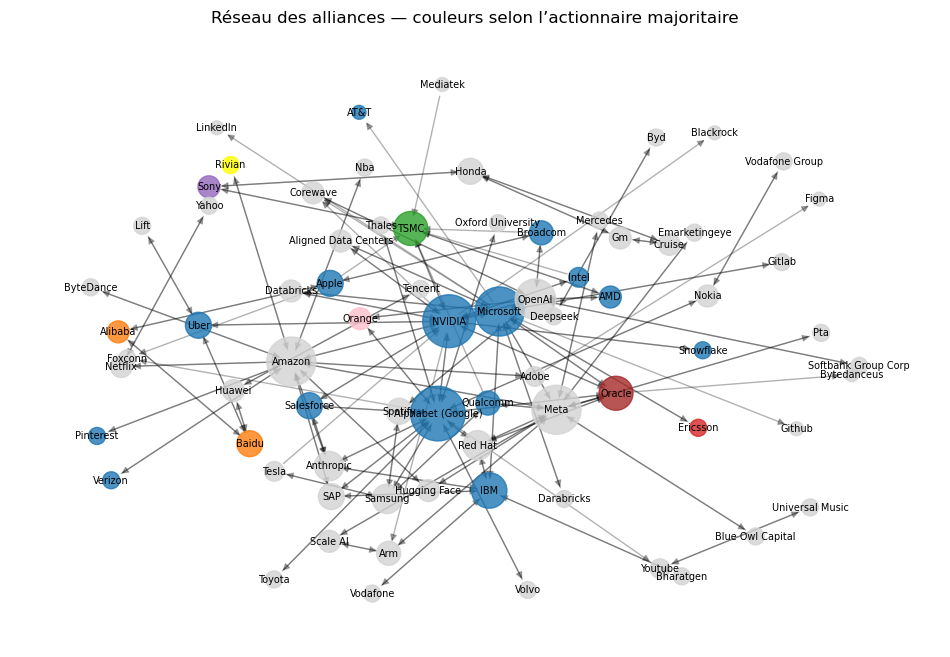

In [70]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.6, seed=42)
colors = []
for n in G.nodes():
    sh = G.nodes[n].get("MajorShareholder","")
    if sh in ["Vanguard","BlackRock", "Primecap Management Company","National Developement Fund","Investor AB","Elon Musk ","French Gov", "Amazon", "Nomura Asset Management", "Ellison"]:
        colors.append({
            "Vanguard":"#1f77b4","BlackRock" : "blue", "Primecap Management Company":"#ff7f0e","National Developement Fund":"#2ca02c",
            "Investor AB":"#d62728","Nomura Asset Management":"#9467bd", "Elon Musk" : "green", "French Gov" : "pink", "Amazon" : "yellow", "Ellison" : "brown"
        }.get(sh, "gray"))
    else:
        colors.append("lightgray")
deg = dict(G.degree())       
node_sizes = [50 + deg[n]*50 for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Réseau des alliances — couleurs selon l’actionnaire majoritaire")
plt.axis("off")
plt.show()


In [32]:
import pandas as pd, re, unicodedata

def canon(s: str) -> str:
    if not isinstance(s, str): return ""
    s = re.sub(r"\s*\([^)]*\)\s*$", "", s)  # retire les (A), (B), etc.
    s = s.replace("\u00a0"," ").strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^a-z0-9]+", "", s)
    return s

nodes_csv = pd.read_csv("companies_clean.csv", dtype=str).fillna("")
nodes_csv["canon_key"] = nodes_csv["Company"].map(canon)

canon_csv = set(nodes_csv["canon_key"])
canon_g = {canon(n) for n in G.nodes()}

not_found = sorted([n for n in G.nodes() if canon(n) not in canon_csv])

print(f"🔎 Entreprises dans le graphe : {len(G.nodes())}")
print(f"🗃 Entreprises dans le CSV : {len(nodes_csv)}")
print(f"⚠️ Nœuds du graphe sans correspondance dans le CSV : {len(not_found)}")
print("Exemples de nœuds non reconnus :", not_found[:20])


🔎 Entreprises dans le graphe : 75
🗃 Entreprises dans le CSV : 98
⚠️ Nœuds du graphe sans correspondance dans le CSV : 36
Exemples de nœuds non reconnus : ['Aligned Data Centers', 'Arm', 'Bharatgen', 'Blackrock', 'Blue Owl Capital', 'Byd', 'Bytedanceus', 'Corewave', 'Darabricks', 'Deepseek', 'Emarketingeye', 'Foxconn', 'Github', 'Gitlab', 'Gm', 'Honda', 'Lift', 'Mediatek', 'Mercedes', 'Meta']
